In [1]:
import pandas as pd
import os, sys
from pathlib import Path

sys.path.append('../src/')

from main.classifier_cost_benefit_calculator import net_gain_curve, plot_net_gain_curve

# Table of Contents
- <b>Load data</b>
- <b>Data preparation</b>
- <b>Model training</b>
- <b>Problem 1: what cut-off should we use for the classifier?</b>
 - <b>Standard approach: find cut-off that maximises F1 score</b>
 - <b>Net-gain approach: find cut-off that maximises expected net gain</b>
- <b>Problem 2: what classifier should we use?</b>
 - <b>Standard approach: select model that maximises AUC</b>
 - <b>Net-gain approach: select model that maximises expected net gain</b>

# Load data

For this tutorial we use the credit card fraud detection dataset (downloaded from https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud): 

In [2]:
df_undspl = pd.read_csv('data/creditcard_undersampled.csv').drop('Unnamed: 0', axis=1)

The original dataset is highly imbalanced: for the sake of simplicity we have undersampled the dataset in order to have a 2/1 ratio between class 0 (genuine transaction) and class 1 (fradulent transaction)

In [3]:
df_undspl.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
1,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
2,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
3,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
4,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1


In [4]:
df_undspl.Class.describe()

count    1476.000000
mean        0.333333
std         0.471564
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Class, dtype: float64

# Data preparation 

Split the dataset into features and target, and into training and test:

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X, y = df_undspl.drop('Class', axis=1), df_undspl['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)

In [7]:
X_train.shape

(988, 30)

In [8]:
X_test.shape

(488, 30)

# Model training 

In [9]:
from sklearn.linear_model import LogisticRegression

In [10]:
lr = LogisticRegression()
lr = lr.fit(X_train, y_train)

### Performance on test set 

In [11]:
from sklearn.metrics import roc_auc_score, average_precision_score, recall_score

In [12]:
y_score_lr = [i[1] for i in lr.predict_proba(X_test)]

In [13]:
print(f"AUC: {round(roc_auc_score(y_test.values, y_score_lr),3)} \n"
      f"Average precision: {round(average_precision_score(y_test.values, y_score_lr),3)} \n"
      f"Recall: {round(recall_score(y_test.values, [1 if i > 0.5 else 0 for i in y_score_lr]),3)}")

AUC: 0.978 
Average precision: 0.972 
Recall: 0.882


A simple logistic regression performs quite well on this dataset. Let's now see how the classifier-profit library can gives us some further insights.

## Problem 1: what cut-off should we use for the classifier?

### Standard approach: find cut-off that maximises F1 score 

A common approach is to ignore cost and gain associated with the confusion matrix and just maximising the F1 score. Let's try this approach here and see what cut-off we obtain.

In [14]:
import numpy as np
from sklearn.metrics import f1_score

In [15]:
cutoff_list = np.arange(0.0, 1.05, 0.05)

In [16]:
s = pd.Series(np.nan,index=cutoff_list)
for cutoff in cutoff_list:
    s.loc[cutoff] = f1_score(y_test, y_score_lr>=cutoff)

In [17]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'F1 score')

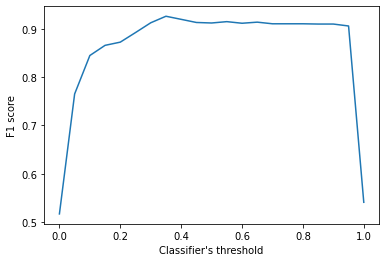

In [18]:
s.plot()
plt.xlabel("Classifier's threshold")
plt.ylabel("F1 score")

In [19]:
s.idxmax()

0.35000000000000003

In [20]:
(y_score_lr > s.idxmax()).mean()

0.3422131147540984

The optimal cut-off we get when we simply maximise for F1 score is 0.35. Around 34.2% of transactions would get classified as fradulent if we follow this approach.

### Net-gain approach: find cut-off that maximises net gain  

The net-gain approach requires an estimate of cost for false positives (fp_cost) and gain for true positives (tp_gain). The result of the analysis are highly dependent on these two input parameters: for this reason we are now going to analyse separately three scenarios for different values of tp_gain and fp_cost. A fourth scenario will also show the importance of another input parameter, the expected prior of class 1 (p_1). 

#### Scenario 1: cost of false positive much smaller than gain for true positive 

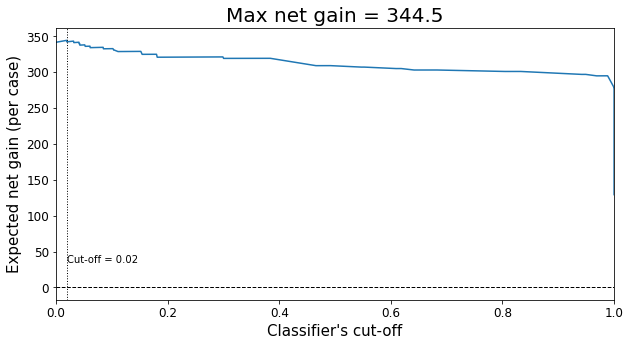

In [52]:
tp_gain = 1000.
fp_cost = 10.

expected_net_gain_series_lr, expected_net_gain_max_lr, optimal_threshold_lr = \
    net_gain_curve(y_test, y_score_lr, tp_gain, fp_cost)

plot_net_gain_curve(expected_net_gain_series_lr,figsize=(10,5))

Fraction of transactions above cut-off in test set:

In [53]:
(y_score_lr > optimal_threshold_lr).mean()

0.7336065573770492

Because the cost of false positive is relatively small compared to the gain for a true positive, the optimal cut-off is very loose: 0.02, meaning that we should flag as potentially fradulent all transactions that get a score above 0.02 (73% of transactions are like that in the test set).

#### Scenario 2: cost for false positive = gain for true positive 

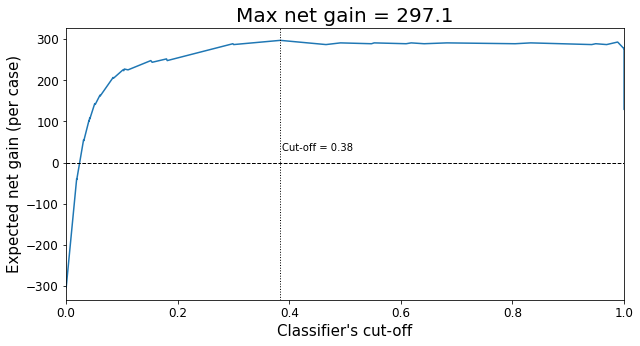

In [54]:
tp_gain = 1000.
fp_cost = 1000.

expected_net_gain_series_lr, expected_net_gain_max_lr, optimal_threshold_lr = \
    net_gain_curve(y_test, y_score_lr, tp_gain, fp_cost)

plot_net_gain_curve(expected_net_gain_series_lr,figsize=(10,5))

In [55]:
optimal_threshold_lr

0.3839312871435987

Fraction of transactions above cut-off in test set:

In [56]:
(y_score_lr > optimal_threshold_lr).mean()

0.3401639344262295

If cost for false positive equals gain for true positives, the optimal cut-off becomes stricter than in the previous scenario: we should flag a transaction as fradulent only if its score is above 0.38. In the test set this would include 34% of all transactions.

#### Scenario 3: cost for false positive >> gain for true positive 

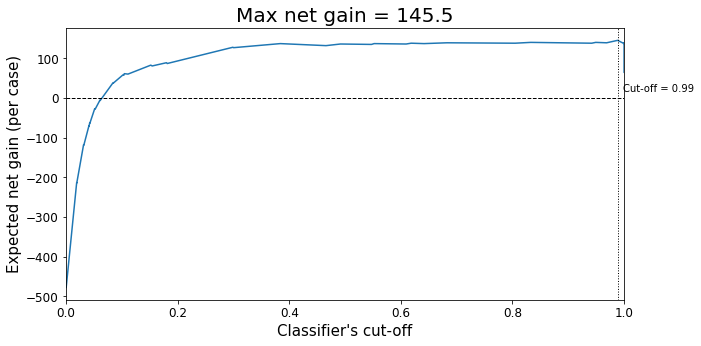

In [57]:
tp_gain = 500.
fp_cost = 1000.

expected_net_gain_series_lr, expected_net_gain_max_lr, optimal_threshold_lr = \
    net_gain_curve(y_test, y_score_lr, tp_gain, fp_cost)

plot_net_gain_curve(expected_net_gain_series_lr,figsize=(10,5))

Fraction of transactions above cut-off in test set:

In [58]:
(y_score_lr > optimal_threshold_lr).mean()

0.29508196721311475

If cost for false positive is much higher than cost of true positive, we are better off by significantly increasing the cut-off, so that we flag transactions as fradulent only if the classifier is very confident. Also notice how in this scenario the expected net gain is significantly lower than in the two previous scenarios: depending on the business context this may suggest that we are better off not using the classifier in the first place.

#### Scenario 4: cost for false positive = gain for true positive, but expected prior of class 1 in production is lower than in the test set (0.1 vs 0.333 in test set)

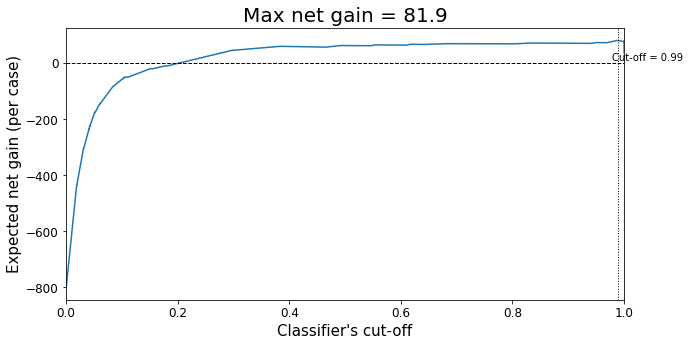

In [59]:
tp_gain = 1000.
fp_cost = 1000.
p_1 = 0.1

expected_net_gain_series_lr, expected_net_gain_max_lr, optimal_threshold_lr = \
    net_gain_curve(y_test, y_score_lr, tp_gain, fp_cost, p_1=p_1)

plot_net_gain_curve(expected_net_gain_series_lr,figsize=(10,5))

This scenario is similar to scenario 2, except that we assume the production data will have a lower prevalence of class 1 (fradulent transactions) than in the test set: as a consequence, even though it is still true that cost of false positive equals the gain of true positive, the gain of true positives is overall less important than in scenario 2 because there are fewer positive cases to find in the first place. Hence the optimal cut-off has increased to the same value recommended in scenario 3 (and expected max net gain has decreased even further).

# Problem 2: what classifier should we use?

Model selection is often done by choosing the model that maximises some performance metric on the evaluation set (e.g. AUC). But what's the commercial benefit of using a model over the other? Our functions let us answer this question,

In [60]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [78]:
tree = DecisionTreeClassifier(random_state=1)
tree = tree.fit(X_train, y_train)

rf = RandomForestClassifier(random_state=1)
rf = rf.fit(X_train, y_train)

y_score_tree = [i[1] for i in tree.predict_proba(X_test)]
y_score_rf = [i[1] for i in rf.predict_proba(X_test)]

### Standard approach: select model that maximises AUC 

In [79]:
print(f"AUC: \n Logistic Regression = {round(roc_auc_score(y_test.values, y_score_lr),3)}"
      f"\n Random Forest = {round(roc_auc_score(y_test.values, y_score_rf),3)}"
      f"\n Decision Tree = {round(roc_auc_score(y_test.values, y_score_tree),3)}")

AUC: 
 Logistic Regression = 0.978
 Random Forest = 0.978
 Decision Tree = 0.918


If we just wanted to maximise AUC, Logistic Regression and Random Forest seem to have similar predictive power.

### Net-gain approach: select model that maximises expected net gain

In [80]:
tp_gain = 1000.
fp_cost = 1000.

_, expected_net_gain_max_lr, _ = net_gain_curve(y_test, y_score_lr, tp_gain, fp_cost)
_, expected_net_gain_max_tree, _ = net_gain_curve(y_test, y_score_tree, tp_gain, fp_cost)
_, expected_net_gain_max_rf, _ = net_gain_curve(y_test, y_score_rf, tp_gain, fp_cost)

In [81]:
print(f"Expected net gains: \n Logistic Regression = {round(expected_net_gain_max_lr,2)}"
     f"\n Random Forest = {round(expected_net_gain_max_rf,2)}"
     f"\n Decision Tree = {round(expected_net_gain_max_tree,2)}")

Expected net gains: 
 Logistic Regression = 297.13
 Random Forest = 301.23
 Decision Tree = 276.64


When we look at the expected net gain for each classifier we find that Random Forest provides higher value than Logistic Regression (at least for the chosen values of tp_gain and fp_cost), despite having similar AUC. This is an insight we would have missed if we had just blindly tried to maximise for AUC or other 'commercially blind' metrics.

P.S. Given that Random Forest introduces more complexity we may still end up choosing Logistic Regression if the difference in net gain is not deemed large enough. But at least we are now able to quantify the commercial gain of a more complex model, and we can weigh it against the cost of model complexity. 